<a href="https://colab.research.google.com/github/boemer00/aot-object-tracking-aws/blob/working_model/working_model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [1]:
!apt-get install awscli -y
!pip install --upgrade urllib3
!pip install --upgrade botocore
!pip install boto3


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  docutils-common fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript groff gsfonts
  imagemagick imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libfftw3-double3 libgs9 libgs9-common libidn12 libijs-0.35 libimagequant0 libjbig2dec0
  libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra
  libmagickwand-6.q16-6 libnetpbm10 libraqm0 libwmflite-0.2-7 mailcap mime-support netpbm
  poppler-data psutils python3-botocore python3-certifi python3-chardet python3-colorama
  python3-dateutil python3-docutils python3-idna python3-jmespath python3-olefile python3-pil
  python3-pyasn1 python3-pygments python3-requests python3-roman python3-rsa python3-s3transfer
  python3-urllib3 python3-yaml sgml-base xml-core
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf f

In [21]:
# this section needs to be organised

import os
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import matplotlib.pyplot as plt

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import pandas as pd
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import functional as F
import torchvision

# AWS S3

In [3]:
# initialise the S3 client
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# list the bucket contents
bucket_name = 'airborne-obj-detection-challenge-training'
result = s3_client.list_objects_v2(Bucket=bucket_name)

# print out the first 10 files
for i, content in enumerate(result.get('Contents', [])):
    if i >= 10:
        break
    print(content['Key'])


part1/ImageSets/groundtruth.csv
part1/ImageSets/groundtruth.json
part1/ImageSets/valid_encounters_maxRange700_maxGap3_minEncLen30.csv
part1/ImageSets/valid_encounters_maxRange700_maxGap3_minEncLen30.json
part1/Images/0001ba865c8e410e88609541b8f55ffc/15549773493822188340001ba865c8e410e88609541b8f55ffc.png
part1/Images/0001ba865c8e410e88609541b8f55ffc/15549773494832603520001ba865c8e410e88609541b8f55ffc.png
part1/Images/0001ba865c8e410e88609541b8f55ffc/15549773495887103050001ba865c8e410e88609541b8f55ffc.png
part1/Images/0001ba865c8e410e88609541b8f55ffc/15549773497216090760001ba865c8e410e88609541b8f55ffc.png
part1/Images/0001ba865c8e410e88609541b8f55ffc/15549773497811591170001ba865c8e410e88609541b8f55ffc.png
part1/Images/0001ba865c8e410e88609541b8f55ffc/15549773499109254600001ba865c8e410e88609541b8f55ffc.png


In [4]:
# create a directory to dowmload images
os.makedirs('dataset', exist_ok=True)

bucket_name = 'airborne-obj-detection-challenge-training'
flight_id = '0001ba865c8e410e88609541b8f55ffc'
sequence_prefix = f'part1/Images/{flight_id}/'

# variables for pagination
image_count = 0
continuation_token = None

# loop to handle pagination
while True:
    if continuation_token:
        result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=sequence_prefix, ContinuationToken=continuation_token)
    else:
        result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=sequence_prefix)

    # check if any objects were found
    if 'Contents' in result:
        for content in result['Contents']:
            file_key = content['Key']

            # download only PNG files
            if file_key.endswith('.png'):
                local_filename = os.path.join('dataset', os.path.basename(file_key))
                s3_client.download_file(bucket_name, file_key, local_filename)
                image_count += 1

    # check if there are more objects to retrieve (pagination)
    if result.get('IsTruncated'):
        continuation_token = result['NextContinuationToken']
    else:
        break

print(f'Downloaded {image_count} images for flight ID {flight_id}.')

Downloaded 1199 images for flight ID 0001ba865c8e410e88609541b8f55ffc.


# Checking the Images

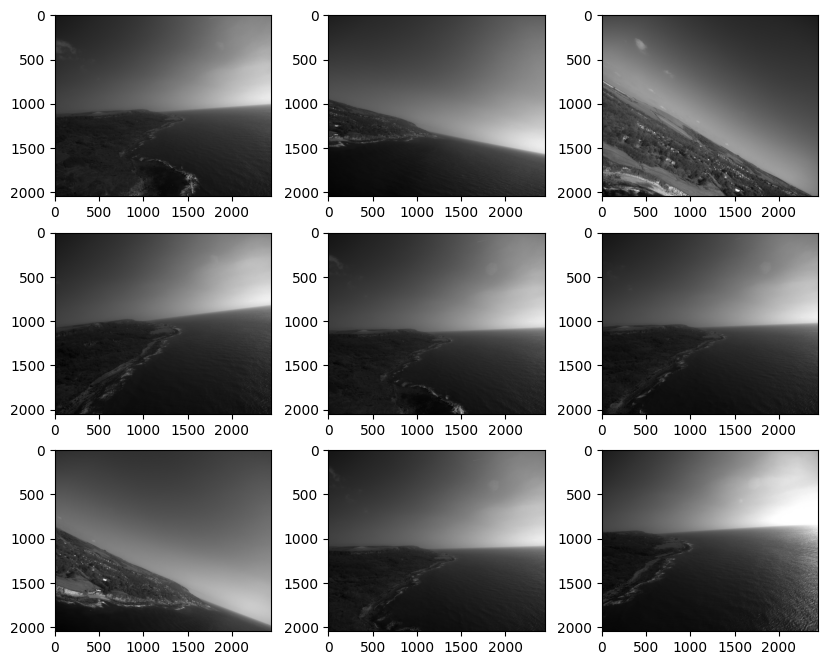

In [5]:
image_folder = 'dataset'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

fig = plt.figure(figsize=(10,8))

for i in range(1, 10):
    img = cv2.imread(os.path.join(image_folder, image_files[i]))
    fig.add_subplot(3, 3, i)
    plt.imshow(img, cmap='gray')

plt.show()

# Annotations

In [6]:
os.makedirs('groundtruth', exist_ok=True)

csv_files = [
    'part1/ImageSets/groundtruth.csv',
    'part1/ImageSets/valid_encounters_maxRange700_maxGap3_minEncLen30.csv'
]

for file in csv_files:
    local_filename = os.path.join('groundtruth', os.path.basename(file))
    s3_client.download_file(bucket_name, file, local_filename)
    print(f"Downloaded {file} to {local_filename}")

print("All downloads completed.")

Downloaded part1/ImageSets/groundtruth.csv to groundtruth/groundtruth.csv
Downloaded part1/ImageSets/valid_encounters_maxRange700_maxGap3_minEncLen30.csv to groundtruth/valid_encounters_maxRange700_maxGap3_minEncLen30.csv
All downloads completed.


In [7]:
import pandas as pd

groundtruth_df = pd.read_csv('groundtruth/groundtruth.csv', index_col=0)
groundtruth_df.head(2)

,time,flight_id,img_name,frame,id,range_distance_m,is_above_horizon,size_width,size_height,gt_left,gt_top,gt_right,gt_bottom
0,1566556045879430639,673f29c3e4b4428fa26bc55d812d45d9,1566556045879430639673f29c3e4b4428fa26bc55d812...,3,NaN,NaN,NaN,2448,2048,NaN,NaN,NaN,NaN
1,1566556046008821070,673f29c3e4b4428fa26bc55d812d45d9,1566556046008821070673f29c3e4b4428fa26bc55d812...,4,NaN,NaN,NaN,2448,2048,NaN,NaN,NaN,NaN


In [8]:
# checking annotations for a single flight
flight_id_1 = '0001ba865c8e410e88609541b8f55ffc'

image_annotations = groundtruth_df[groundtruth_df['flight_id'] == flight_id_1]
image_annotations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1199 entries, 684441 to 685639
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              1199 non-null   int64  
 1   flight_id         1199 non-null   object 
 2   img_name          1199 non-null   object 
 3   frame             1199 non-null   int64  
 4   id                324 non-null    object 
 5   range_distance_m  324 non-null    float64
 6   is_above_horizon  324 non-null    float64
 7   size_width        1199 non-null   int64  
 8   size_height       1199 non-null   int64  
 9   gt_left           324 non-null    float64
 10  gt_top            324 non-null    float64
 11  gt_right          324 non-null    float64
 12  gt_bottom         324 non-null    float64
dtypes: float64(6), int64(4), object(3)
memory usage: 131.1+ KB


In [9]:
valid_encounters_df = pd.read_csv('groundtruth/valid_encounters_maxRange700_maxGap3_minEncLen30.csv', index_col=0)
valid_encounters_df = valid_encounters_df[valid_encounters_df['flight_id'] == flight_id_1]
valid_encounters_df

,encounter_id,flight_id,framemin,framemax,framecount,enc_len_with_gaps,is_above_horizon,min_enc_range,max_enc_range,median_enc_range,mean_enc_range
0,0.0,0001ba865c8e410e88609541b8f55ffc,229,325,97,97,-1.0,188.553218,698.099154,437.850254,439.41824


# Image Processing

In [10]:
import cv2

dataset_dir = 'dataset'
resized_dir = 'resized_dataset'

if not os.path.exists(resized_dir):
    os.makedirs(resized_dir, exist_ok=True)

output_size = (512, 512)

# list of images for a specific flight
flight_images = groundtruth_df[groundtruth_df['flight_id'] == flight_id_1]['img_name'].unique()

for image_file in flight_images:
    if image_file.endswith('.png'):
        # load
        image_path = os.path.join(dataset_dir, image_file)
        if not os.path.exists(image_path):
            print(f"Warning: Image not found: {image_path}")
            continue
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # resize
        resized_image = cv2.resize(image, output_size)

        # save
        output_path = os.path.join(resized_dir, image_file)
        cv2.imwrite(output_path, resized_image)

print(f'Resized {len(flight_images)} images for flight {flight_id_1}.')

Resized 1199 images for flight 0001ba865c8e410e88609541b8f55ffc.


# Model

Steps to implement Faster R-CNN:

*   Prepare the Dataset for Faster R-CNN
* Define the Faster R-CNN Model
* Train the Model
* Evaluate the Model
* Measure the Model’s Performance




Example for frame level data (multiple per frame):


```
{
    'time': 1550844897919368155,
    'blob': {
        'frame': 480,
        'range_distance_m': nan # signifies, it was an unplanned object
    },
    'id': 'Bird2',
    'bb': [1013.4, 515.8, 6.0, 6.0],
    'labels': {'is_above_horizon': 1},
    'flight_id': '280dc81adbb3420cab502fb88d6abf84',
    'img_name': '1550844897919368155280dc81adbb3420cab502fb88d6abf84.png'
}
```



In [14]:
groundtruth_df.columns

Index(['time', 'flight_id', 'img_name', 'frame', 'id', 'range_distance_m',
       'is_above_horizon', 'size_width', 'size_height', 'gt_left', 'gt_top',
       'gt_right', 'gt_bottom'],
      dtype='object')

## Prepare

In [15]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
import cv2

class AirborneObjectDetection(Dataset):
    def __init__(self, img_dir, annotations_file, flight_id, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load and filter annotations for the given flight_id
        self.annotations = pd.read_csv(annotations_file)
        self.annotations = self.annotations[self.annotations['flight_id'] == flight_id]

        # Get all images in the directory
        self.all_images = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_name = self.all_images[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Load the image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Image {img_name} not found or unable to load.")

        # Convert the image to a tensor
        img = F.to_tensor(img)

        boxes = []
        labels = []

        # Get annotations for the current image
        image_annotations = self.annotations[self.annotations['img_name'] == img_name]

        if not image_annotations.empty:
            # Iterate through annotations for objects in the image
            for _, row in image_annotations.iterrows():
                # Extract bounding box coordinates
                xmin = row['gt_left']
                ymin = row['gt_top']
                xmax = row['gt_right']
                ymax = row['gt_bottom']

                # Append the bounding box in [xmin, ymin, xmax, ymax] format
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(1)  # Assuming all objects are of the same class
        else:
            # Handle the case where there are no objects in the image
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            target = {'boxes': boxes, 'labels': labels}
            if self.transform:
                img, target = self.transform(img, target)
            return img, target

        # Convert boxes and labels to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        # Apply transformations, if any
        if self.transform:
            img, target = self.transform(img, target)

        return img, target


In [20]:
# create the dataset
dataset = AirborneObjectDetection(
    img_dir='resized_dataset',
    annotations_file='groundtruth/groundtruth.csv',
    flight_id=flight_id_1
)

# fetch a sample
img, target = dataset[789]

print(f"Image shape: {img.shape}")
print(f"Target: {target}")

Image shape: torch.Size([1, 512, 512])
Target: {'boxes': tensor([[1479.7789, 1093.0994, 1485.7789, 1099.0994]]), 'labels': tensor([1])}


In [23]:
# split the dataset
dataset_size = len(dataset)
test_size = int(0.2 * dataset_size)
train_size = dataset_size - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

## Train model

In [24]:
# create DataLoaders
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 4

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

In [25]:
# define the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# move model to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# set up optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 138MB/s]


In [ ]:
# training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    lr_scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

## Save model